In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# 1 Least squares and linear basis functions models
## 1.1 Least squares

In [1]:
def least_squares(y, tx):
    """calculate the least squares solution."""
    # ***************************************************
    # least squares:
    N = len(y)
    '''cost = -1/N*np.dot(np.transpose(tx), y - np.dot(tx, w))
    optimalWeights = np.dot(np.dot(np.inverse(np.dot(np.transpose(tx), tx)), np.transpose(tx)), y)'''
    
    tx_T = tx.transpose()
    a = np.dot(tx_T,tx)
    b = np.dot(tx_T,y)
    
    #loss = 1/(2*N) * np.dot(np.transpose(y-tx), y-tx)
    
    # returns mse, and optimal weights
    return np.linalg.solve(a,b)
    
    # ***************************************************

### Load the data
Here we will reuse the dataset `height_weight_genders.csv` from previous exercise section to check the correctness of your implementation. Please compare it with your previous result.

In [2]:
from helpers import *
from grid_search import generate_w, get_best_parameters, grid_search
from plots import grid_visualization
from costs import *
import datetime

def test_your_least_squares():
    height, weight, gender = load_data_from_ex02(sub_sample=False, add_outlier=False)
    x, mean_x, std_x = standardize(height)
    y, tx = build_model_data(x, weight)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # least square or grid search:
    w0, w1 = generate_w(num_intervals=100)
    grid_search(y, tx, w0, w1)
    
    start_time = datetime.datetime.now()
    optimalWeights = least_squares(y, tx)
    end_time = datetime.datetime.now()
    execution_time_LS = (end_time - start_time).total_seconds()
    lossesLS = compute_loss(y, tx, optimalWeights)




    print(optimalWeights[0])
            
    #### GRAPHICAL PART #### 
    # Generate the grid of parameters to be swept
    grid_w0, grid_w1 = generate_w(num_intervals=100)

    # Start the grid search
    start_time = datetime.datetime.now()
    grid_losses = grid_search(y, tx, grid_w0, grid_w1)

    # Select the best combinaison - GridSearch
    loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
    end_time = datetime.datetime.now()
    execution_time = (end_time - start_time).total_seconds()
    
    # Print the results
    print("Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
          l=loss_star, w0=w0_star, w1=w1_star, t=execution_time))
    
    w0_star=optimalWeights[0]
    w1_star=optimalWeights[1]
    
    print("Least Squares: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
          l=lossesLS, w0=w0_star, w1=w1_star, t=execution_time_LS))

    # Plot the results
    fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
    fig2 = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
    fig.set_size_inches(10.0,6.0)
    fig.savefig("grid_plot")  # Optional saving
    fig2.set_size_inches(10.0,6.0)
    fig2.savefig("LeastSquares")  # Optional saving
    
    # this code should compare the optimal weights obtained 
    # by least squares vs. grid search
    # ***************************************************

Test it here

In [3]:
test_your_least_squares()

73.2939220021
Grid Search: loss*=15.55870336860953, w0*=72.72727272727272, w1*=13.636363636363626, execution time=0.752 seconds
Least Squares: loss*=15.3858878688294, w0*=73.29392200210522, w1*=13.47971243498904, execution time=0.002 seconds


## 1.2 Least squares with a linear basis function model
Start from this section, we will use the dataset `dataEx3.csv`.

### Implement polynomial basis functions

In [4]:
# load dataset
x, y = load_data()
print("shape of x {}".format(x.shape))
print("shape of y {}".format(y.shape))

shape of x (50,)
shape of y (50,)


In [5]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    # ***************************************************
    # polynomial basis function:
    phi_mat = np.empty([len(x),degree+1])
    for i in range(len(x)):
        for j in range(degree+1):
            phi_mat[i,j] = x[i]**j
                
    return phi_mat
    # this function should return the matrix formed
    # by applying the polynomial basis to the input data
    # ***************************************************

Let us play with polynomial regression. Note that we will use your implemented function `compute_mse`. Please copy and paste your implementation from exercise02.

In [6]:
from costs import compute_loss
from plots import *

def polynomial_regression():
    """Constructing the polynomial basis function expansion of the data,
       and then running least squares regression."""
    # define parameters
    degrees = [1, 3, 7, 12]
    
    # define the structure of the figure
    num_row = 2
    num_col = 2
    f, axs = plt.subplots(num_row, num_col)

    for ind, degree in enumerate(degrees):
        # ***************************************************
        # form the data to do polynomial regression.: 
        phi_mat = build_poly(x, degree)
        weights = least_squares(y, phi_mat)
        mse = compute_loss(y,phi_mat,weights)
        # ***************************************************
        
        # ***************************************************
        # least square and calculate RMSE:
        rmse = np.sqrt(mse*2)
        # ***************************************************
        print("Processing {i}th experiment, degree={d}, rmse={loss}".format(
              i=ind + 1, d=degree, loss=rmse))
        # plot fit
        plot_fitted_curve(
            y, x, weights, degree, axs[ind // num_col][ind % num_col])
    plt.tight_layout()
    plt.savefig("visualize_polynomial_regression")
    plt.show()

Run polynomial regression

Processing 1th experiment, degree=1, rmse=0.47187607963421874
Processing 2th experiment, degree=3, rmse=0.258582776677375
Processing 3th experiment, degree=7, rmse=0.24965870360907585
Processing 4th experiment, degree=12, rmse=0.24125747399269168


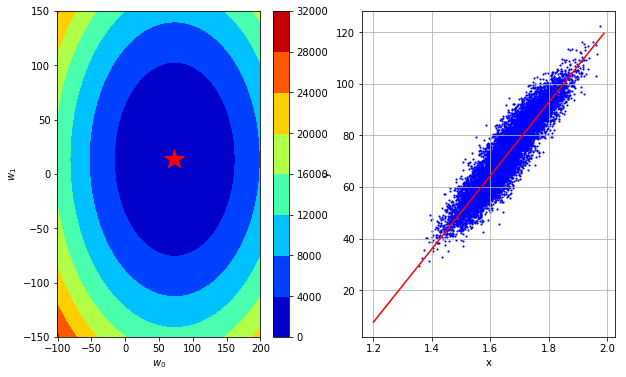

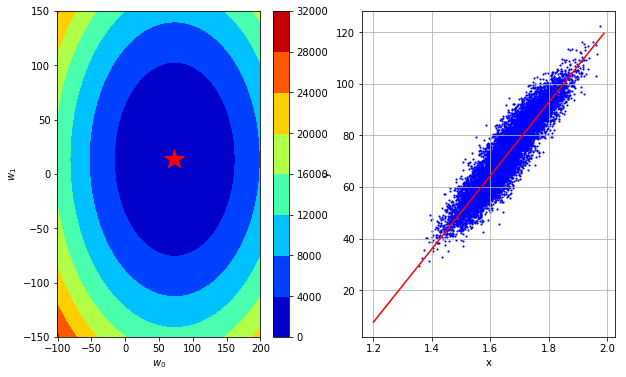

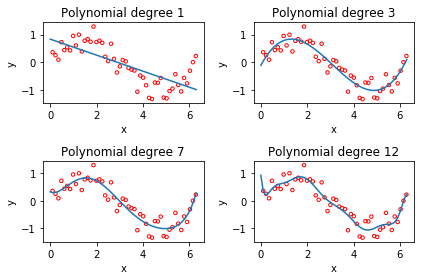

In [7]:
polynomial_regression()

# 2 Evaluating model predication performance


Let us show the train and test splits for various polynomial degrees. First of all, please fill in the function `split_data()`

In [14]:
def split_data(x, y, ratio, seed=1):
    """
    split the dataset based on the split ratio. If ratio is 0.8 
    you will have 80% of your data set dedicated to training 
    and the rest dedicated to testing
    """
    # set seed
    np.random.seed(seed)
    # ***************************************************
    # split the data based on the given ratio:
    testx = []
    testy = []
    trainingx = []
    trainingy = []
    
    i = 0
    for i in range(len(x)):
        if (np.random.binomial(1, ratio)):
            trainingx.append(x[i])
            trainingy.append(y[i]) 
        else:
            testx.append(x[i])
            testy.append(y[i]) 
            
    return testx, testy, trainingx, trainingy 
    # ***************************************************

Then, test your `split_data` function below.

In [15]:
def train_test_split_demo(x, y, degree, ratio, seed):
    """polynomial regression with different split ratios and different degrees."""
    # ***************************************************
    # split the data, and return train and test data: 
    testx, testy, trainingx, trainingy  = split_data(x, y, ratio, seed)
    # ***************************************************
    # ***************************************************
    # form train and test data with polynomial basis function: 
    phi_mat_te = build_poly(testx, degree)
    weights_te = least_squares(testy, phi_mat_te)
    
    phi_mat_tr = build_poly(trainingx, degree)
    weights_tr = least_squares(trainingy, phi_mat_tr)
    # calcualte weight through least square.:
    mse_tr = compute_loss(trainingy,phi_mat_tr,weights_tr)
    mse_te = compute_loss(testy,phi_mat_te,weights_te)

    # ***************************************************
    # ***************************************************
    # ***************************************************
    # calculate RMSE for train and test data,
    # and store them in rmse_tr and rmse_te respectively: 
    rmse_tr = np.sqrt(mse_tr*2)
    rmse_te = np.sqrt(mse_te*2)
    
    return rmse_tr, rmse_te

In [16]:
seed = 6
degrees = [1, 3, 7, 12]
split_ratios = [0.9, 0.5, 0.1]

for split_ratio in split_ratios:
    for degree in degrees:
        print(split_ratio)
        print(degree)
        rmse_tr, rmse_te = train_test_split_demo(x, y, degree, split_ratio, seed)
        print(rmse_te)
        print(rmse_tr)

0.9
1
0.31478827564
0.477910513815
0.9
3
0.00164262224865
0.26285112877
0.9
7
1.84305777784e-11
0.249040336779
0.9
12
6.28442778358e-12
0.239969813978
0.5
1
0.502180758576
0.435892222154
0.5
3
0.195692932954
0.2750456898
0.5
7
0.186212454359
0.258694948234
0.5
12
0.174255080885
0.232483003373
0.1
1
0.477910513815
0.31478827564
0.1
3
0.26285112877
0.00164262224865
0.1
7
0.249040336779
1.84305777784e-11
0.1
12
0.239969813978
6.28442778358e-12


# 3 Ridge Regression
Please fill in the function below.

In [52]:
def ridge_regression(y, tx, lambda_):
    """implement ridge regression."""
    # ***************************************************
    # ridge regression: 
    lambda_=lambda_/(2*len(y))
    a=np.dot(np.transpose(tx),tx)+lambda_*np.identity(tx.shape[1])
    b=np.dot(np.transpose(tx),y)
    #mse=compute_MSE(y,tx,w_opt) #compute error
    return np.linalg.solve(a,b) #this way is 1 µs faster
    # ***************************************************

In [59]:
def ridge_regression_demo(x, y, degree, ratio, seed):
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-5, 0, 15)
    # ***************************************************
    # split the data, and return train and test data: 
    testx, testy, trainingx, trainingy  = split_data(x, y, ratio, seed)
    # ***************************************************
    # ***************************************************
    # form train and test data with polynomial basis function: 
    # ***************************************************

    rmse_tr = []
    rmse_te = []
    tr_x,tr_y,te_x,te_y = split_data(x, y, ratio, seed)
    tr_mat = build_poly(tr_x, degree)
    te_mat = build_poly(te_x, degree)
    for ind, lambda_ in enumerate(lambdas):
        # ***************************************************
        weights_tr = ridge_regression(tr_y, tr_mat,lambda_)
        weights_te = ridge_regression(te_y, te_mat,lambda_)
        mse_tr = compute_loss(trainingy,tr_mat,weights_tr)
        mse_te = compute_loss(testy,te_mat,weights_te)
        rmse_tr.append(mse_tr)
        rmse_te.append(mse_te)
        # ridge regression with a given lambda
        # ***************************************************
        #print("proportion={p}, degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
               #p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
        
    # Plot the obtained results
    plot_train_test(rmse_tr, rmse_te, lambdas, degree)

In [60]:
seed = 56
degree = 7
split_ratio = 0.5
ridge_regression_demo(x, y, degree, split_ratio, seed)